#### Imports and random seeds

In [1]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_model_optimization as tfmot
import zlib
import matplotlib.pyplot as plt

In [2]:
#setup a random seed
seed = 42

tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# Make sure we don't get any GPU errors
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#### Data downloading and train-test-val split

In [4]:
zip_path = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip", 
    fname='jena_climate_2009_2016.csv.zip', 
    extract=True, 
    cache_dir='.', cache_subdir='data')

csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
column_indices = [2,5]
columns = df.columns[column_indices]
data = df[columns].values.astype(np.float32)

data[:5]

array([[-8.02, 93.3 ],
       [-8.41, 93.4 ],
       [-8.51, 93.9 ],
       [-8.31, 94.2 ],
       [-8.27, 94.1 ]], dtype=float32)

In [6]:
n = len(data)
train_data = data[0:int(n*0.7)]
val_data = data[int(n*0.7):int(n*0.9)]
test_data = data[int(n*0.9):]

In [7]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

#### Window generator and Multiple-Output_MAE

In [8]:
class WindowGenerator:
    def __init__(self, input_width, label_width, num_features, mean, std):
        self.input_width = input_width
        self.label_width = label_width
        self.num_features = num_features
        self.mean = tf.reshape(tf.convert_to_tensor(mean), [1, 1, 2])
        self.std = tf.reshape(tf.convert_to_tensor(std), [1, 1, 2])

    def split_window(self, features):
        # features -> set of sequences made of input_width + label_width values each. [#batch, (input+label)_width, 2] 
        inputs = features[:, :-self.label_width, :]
        labels = features[:, -self.label_width:, :]

        inputs.set_shape([None, self.input_width, self.num_features])
        labels.set_shape([None, self.label_width, self.num_features])
        
        return inputs, labels

    def normalize(self, features):
        features = (features - self.mean) / (self.std + 1.e-6)

        return features

    def preprocess(self, features):
        inputs, labels = self.split_window(features)
        inputs = self.normalize(inputs)

        return inputs, labels

    def make_dataset(self, data, reshuffle):
        # Creates a dataset of sliding windows over a timeseries provided as array
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                data=data, # consecutive data points
                targets=None, # None -> the dataset will only yield the input data
                sequence_length=self.input_width + self.label_width, # Length of the output sequences
                sequence_stride=1, # Period between successive output sequences
                batch_size=32) # Number of timeseries samples in each batch 
        
        # from each set of sequences it splits data to get input and labels and then normalize
        ds = ds.map(self.preprocess)

        # so the mapping is done only once
        ds = ds.cache()
        if reshuffle:
            ds = ds.shuffle(100, reshuffle_each_iteration=True)

        return ds

In [9]:
class MultiOutputMAE(tf.keras.metrics.Metric):

    def __init__(self, name='mean_absolute_error', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total = self.add_weight('total', initializer='zeros', shape=(2,))
        self.count = self.add_weight('count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None): 
        error = tf.abs(y_pred - y_true)
        error = tf.reduce_mean(error, axis=[0,1])
        self.total.assign_add(error)
        self.count.assign_add(1.)
        return
    
    def reset_state(self):
        self.count.assign(tf.zeros_like(self.count))
        self.total.assign(tf.zeros_like(self.total))
    
    def result(self):
        result = tf.math.divide_no_nan(self.total, self.count)
        return result

In [10]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist = hist[1:]
    hist['epoch'] = history.epoch [1:]
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label='Val Error')
    plt.legend()

In [11]:
input_width = 6
label_width = 9 # 3 or 9
num_features = 2

generator = WindowGenerator(input_width, label_width, num_features, mean=mean, std=std)
train_ds = generator.make_dataset(train_data, reshuffle=True)
val_ds = generator.make_dataset(val_data, reshuffle=False)
test_ds = generator.make_dataset(test_data, reshuffle=False)

#### Base Model

In [12]:
alpha = 0.25
sparsity = 0.9

mlp = tf.keras.Sequential([
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=int(128*alpha), activation='relu'), 
    tf.keras.layers.Dense(units=int(128*alpha), activation='relu'), 
    tf.keras.layers.Dense(units=label_width*num_features),
    tf.keras.layers.Reshape([label_width, num_features])
])

In [13]:
# alpha = 0.07
# sparsity=0.7 

# cnn = tf.keras.Sequential([ 
#     tf.keras.layers.Conv1D(filters=int(64*alpha), kernel_size=(3,), activation='relu'), 
#     tf.keras.layers.Flatten(), 
#     tf.keras.layers.Dense(units=int(64*alpha), activation='relu'), 
#     tf.keras.layers.Dense(units=num_features*label_width),
#     tf.keras.layers.Reshape([label_width, num_features])
# ])

In [14]:
loss = tf.losses.MeanSquaredError()
optimizer = tf.optimizers.Adam()
metrics = [MultiOutputMAE()] 

In [15]:
checkpoint_filepath = f'./checkpoints/base_{label_width}/'

if not os.path.exists(checkpoint_filepath):
    os.makedirs(checkpoint_filepath)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #based on the mean_squared_error results the checkpoint will store the model with the lowest error.
    save_best_only=True)

In [16]:
base_model = mlp
base_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

history = base_model.fit(train_ds,   
    epochs=20, 
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback]
    )

base_model.load_weights(checkpoint_filepath)

Epoch 1/20
9200/9200 [==============================] - 57s 6ms/step - loss: 104.2201 - mean_absolute_error: 4.2195 - val_loss: 9.5073 - val_mean_absolute_error: 1.9331
Epoch 2/20
9200/9200 [==============================] - 50s 5ms/step - loss: 7.7094 - mean_absolute_error: 1.6069 - val_loss: 7.7489 - val_mean_absolute_error: 1.6835
Epoch 3/20
9200/9200 [==============================] - 51s 6ms/step - loss: 7.2872 - mean_absolute_error: 1.5183 - val_loss: 7.0153 - val_mean_absolute_error: 1.4614
Epoch 4/20
9200/9200 [==============================] - 51s 6ms/step - loss: 7.1683 - mean_absolute_error: 1.5044 - val_loss: 6.6483 - val_mean_absolute_error: 1.4125
Epoch 5/20
9200/9200 [==============================] - 51s 6ms/step - loss: 7.0130 - mean_absolute_error: 1.4807 - val_loss: 8.7829 - val_mean_absolute_error: 1.7743
Epoch 6/20
9200/9200 [==============================] - 50s 5ms/step - loss: 6.9405 - mean_absolute_error: 1.4707 - val_loss: 8.1357 - val_mean_absolute_error: 1.7

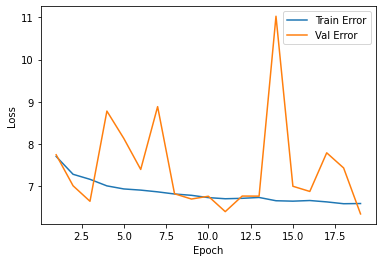

In [17]:
plot_history(history)

#### Pruning

In [18]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

pruning_params = {
	'pruning_schedule':
		tfmot.sparsity.keras.PolynomialDecay(
		initial_sparsity=0.30,
		final_sparsity=sparsity,
		begin_step=len(train_ds)*3,
		end_step=len(train_ds)*15)}
        
model_for_pruning = prune_low_magnitude(base_model, **pruning_params)

model_sparcity_callback = tfmot.sparsity.keras.UpdatePruningStep()

C:\Users\juanm\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)
C:\Users\juanm\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
C:\Users\juanm\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)


In [19]:
model_for_pruning.compile(loss=loss, optimizer=optimizer, metrics=metrics)

checkpoint_filepath = f'./checkpoints/prun_{label_width}/'

if not os.path.exists(checkpoint_filepath):
    os.makedirs(checkpoint_filepath)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #based on the mean_squared_error results the checkpoint will store the model with the lowest error.
    save_best_only=True)

In [20]:
history = model_for_pruning.fit(train_ds,   
    epochs=20, 
    validation_data=val_ds, 
    callbacks=[model_sparcity_callback, model_checkpoint_callback]
    )

model_for_pruning.load_weights(checkpoint_filepath)

Epoch 1/20
9200/9200 [==============================] - 87s 9ms/step - loss: 6.5890 - mean_absolute_error: 1.4052 - val_loss: 6.5854 - val_mean_absolute_error: 1.4231
Epoch 2/20
9200/9200 [==============================] - 85s 9ms/step - loss: 6.5350 - mean_absolute_error: 1.4126 - val_loss: 9.0816 - val_mean_absolute_error: 1.7891
Epoch 3/20
9200/9200 [==============================] - 84s 9ms/step - loss: 6.5857 - mean_absolute_error: 1.4254 - val_loss: 19.8516 - val_mean_absolute_error: 3.4634
Epoch 4/20
9200/9200 [==============================] - 84s 9ms/step - loss: 6.4865 - mean_absolute_error: 1.3951 - val_loss: 6.5235 - val_mean_absolute_error: 1.4009
Epoch 5/20
9200/9200 [==============================] - 83s 9ms/step - loss: 6.4442 - mean_absolute_error: 1.3845 - val_loss: 6.7818 - val_mean_absolute_error: 1.4802
Epoch 6/20
9200/9200 [==============================] - 83s 9ms/step - loss: 6.4467 - mean_absolute_error: 1.3908 - val_loss: 7.6252 - val_mean_absolute_error: 1.53

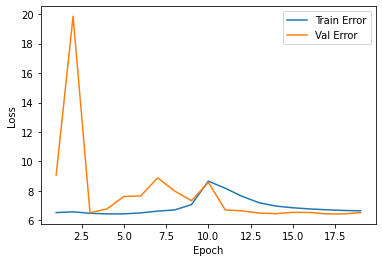

In [21]:
plot_history(history)

In [22]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)

converter.optimizations = [
    tf.lite.Optimize.EXPERIMENTAL_SPARSITY, # Enables size reduction optimization. 
    tf.lite.Optimize.DEFAULT # Enables quantization at conversion.
    #tf.lite.Optimize.OPTIMIZE_FOR_SIZE
]
converter.target_spec.supported_types = [tf.float16]

In [23]:
tflite_buffer = converter.convert()
tflite_compressed = zlib.compress(tflite_buffer)

INFO:tensorflow:Assets written to: C:\Users\juanm\AppData\Local\Temp\tmpql1uyc__\assets


INFO:tensorflow:Assets written to: C:\Users\juanm\AppData\Local\Temp\tmpql1uyc__\assets


#### save TF Lite Model

In [24]:
MODEL_FILE_NAME = f'model_{label_width}.tflite'

if not os.path.exists(f'./models/'):
    os.makedirs(f'./models/')

saved_model_dir = os.path.join(f'./models/', MODEL_FILE_NAME)

with open(saved_model_dir, 'wb') as f:
    f.write(tflite_compressed)

print('File size: ' + str(round(os.path.getsize(saved_model_dir)/1024, 4)) + ' Kilobytes')

File size: 2.4658 Kilobytes


#### save test dataset

In [25]:
tf.data.experimental.save(test_ds, './th_test')

#### On the edge side

In [26]:
# import zlib

# input_width = 6
# label_width = 3 # 3 or 9
# num_features = 2

# MODEL_FILE_NAME = f'model_{label_width}.tflite'
# saved_model_dir = os.path.join(f'./models/{MODEL}_{ID}/', MODEL_FILE_NAME)

TEST_DIR = './th_test/'

In [27]:
saved_model_dir

'./models/model_9.tflite'

In [28]:
with open(saved_model_dir, 'rb') as fp:
    decomp_model = zlib.decompress(fp.read())
    decomp_model_path = saved_model_dir[:-4] # .tf file
    
    file = open(decomp_model_path,'wb')
    file.write(decomp_model)
    file.close()

print('Compressed-File size: ' + str(round(os.path.getsize(saved_model_dir)/1024, 4)) + ' Kilobytes')
print('Decompressed-File size: ' + str(round(os.path.getsize(decomp_model_path)/1024, 4)) + ' Kilobytes')

Compressed-File size: 2.4658 Kilobytes
Decompressed-File size: 7.6172 Kilobytes


In [29]:
tensor_specs = (tf.TensorSpec([None, input_width, num_features], dtype=tf.float32),
 tf.TensorSpec([None,label_width, num_features]))

test_ds = tf.data.experimental.load(TEST_DIR, tensor_specs)

In [30]:
test_ds = test_ds.unbatch().batch(1)

In [31]:
interpreter = tf.lite.Interpreter(model_path=saved_model_dir[:-4])
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.allocate_tensors()

In [32]:
error = 0
for i,(input, labels) in enumerate(test_ds):
    interpreter.set_tensor(input_details[0]['index'], input)
    interpreter.invoke()
    tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
    mae = np.mean(np.abs(tflite_model_predictions - labels), axis=1)

    error = error + mae

error_temp = error[0,0]/(i+1)
error_hum = error[0,1]/(i+1)

print('T MAE: ', error_temp)
print('Rh MAE:', error_hum)


T MAE:  0.5703628588673232
Rh MAE: 2.2828865702749632
